In [2]:
from model import VggForegroundPretrained
import torch
width = 320
height = 240
n_class = 3

net = VggForegroundPretrained(n_class=n_class, width=width, height=height)
load_path = "./vgg-foreground-weights_fine_tuning.pth"

load_weights = torch.load(load_path, map_location={'cuda:0': 'cpu'})
net.load_state_dict(load_weights)

<All keys matched successfully>

In [3]:
fore_feature = net.fore_features
middle_features = net.middle_features
fc6_cam = net.fc6_cam
fc6_dropout = net.fc6_dropout
fc7_cam = net.fc7_cam

In [4]:
import numpy as np
CAM_scores =list(net.fc7_cam.parameters())
params = list(net.scores.parameters())

In [72]:
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

path = "../../dataset/val/0/car_744.jpg"
image = Image.open(path).convert("RGB")
image = image.resize((width, height))

inputs = transform(image)
inputs = inputs.view(1, 3, height, width)

In [73]:
h = inputs
h = fore_feature(h)
h = middle_features(h)
h = fc6_cam(h)
h = fc6_dropout(h)
h = fc7_cam(h)
h = h.detach().cpu().numpy()

In [76]:
heat_maps = np.zeros((3, 30, 40))
localization = np.zeros((3, 30, 40))

In [77]:
for i in range(3):
    w = params[0][i].detach().cpu().numpy()
    heat_maps[i, :, :] = np.sum(h[0] * w[:, None, None], axis=0)
    localization[i, :, :] = heat_maps[i, :, :] > 0.7 * np.max(heat_maps[i])

(1024,)
(1024,)
(1024,)


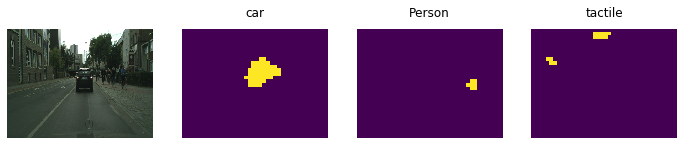

In [80]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12, 4))

ax = f.add_subplot(1, 4, 1)

ax.imshow(np.asarray(image))
ax.axis('off')

ax = f.add_subplot(1, 4, 2)
ax.matshow(localization[0])
ax.set_title('car')
ax.axis('off')

ax = f.add_subplot(1, 4, 3)
ax.matshow(localization[1])
ax.set_title('Person')
ax.axis('off')

ax = f.add_subplot(1, 4, 4)
ax.matshow(localization[2])
ax.set_title('tactile')
ax.axis('off')
plt.show()